In [243]:
from fastai.vision import *
from pathlib import Path, PosixPath
import os
import numpy as np
from random import random as r

In [312]:
crop_size = 700
re_size = 200
rf = re_size / crop_size
cont_px = 4 # 16 for full cnt
C = 13

class WrsImageList(ImageList):
    def get(self, i):
        anno_path = self.items[i]
        with open(anno_path) as f:
            xmin, ymin, xmax, ymax = map(int, f.readline().split(','))
        dataset_path = anno_path.parent.parent / "dataset"
        img_path =  dataset_path / "{}_{}.png".format(*anno_path.name.split('_')[:2])
        img = self.open(img_path)
        _pad = int(cont_px * crop_size / re_size)
        pad(img, crop_size // 2 + _pad)
        cy = (ymin + ymax) // 2 + round((r()-0.5) * 2 * cont_px * rf + cont_px / rf)
        cx = (xmin + xmax) // 2 + round((r()-0.5) * 2 * cont_px * rf + cont_px / rf)
        img = Image(img.data[:, cy:cy+crop_size, cx:cx+crop_size])
        img.resize(re_size)
        return Image(img.data)
    
    @classmethod
    def from_folder(cls, path, **kwargs):
        return cls(Path(path).glob('*'), **kwargs)
    


def label_func_class(p):
    c = int(p.name.split('_')[-1])
    return c
    
def valid_func(p, val_scenes: List[int]):
    return int(p.name.split("_")[0]) in val_scenes

def label_func_center(p):
    # TODO: support none type for no signal
    img_id = p.name.split('.')[0]
    anno_dir = p.parent.parent / "annotations"
    pts = np.zeros((C, 2))
    pts.fill(0)
    for anno_path in anno_dir.glob(img_id + "*"):
        obj_id = int(anno_path.name.split('_')[-1])
        with open(anno_path) as f:
            xmin, ymin, xmax, ymax = map(int, f.readline().split(','))
            pts[obj_id] = (ymin + ymax) / 2, (xmin + xmax) / 2
    return Tensor(pts)

In [313]:
val_scenes = list(range(20, 25))
data = (
    WrsImageList.from_folder("annotations")
    .split_by_valid_func(partial(valid_func, val_scenes=val_scenes))
    .label_from_func(label_func_class)
    .transform(get_transforms(flip_vert=True, p_affine=0))
    .databunch(bs=16)
    .normalize(imagenet_stats)
)

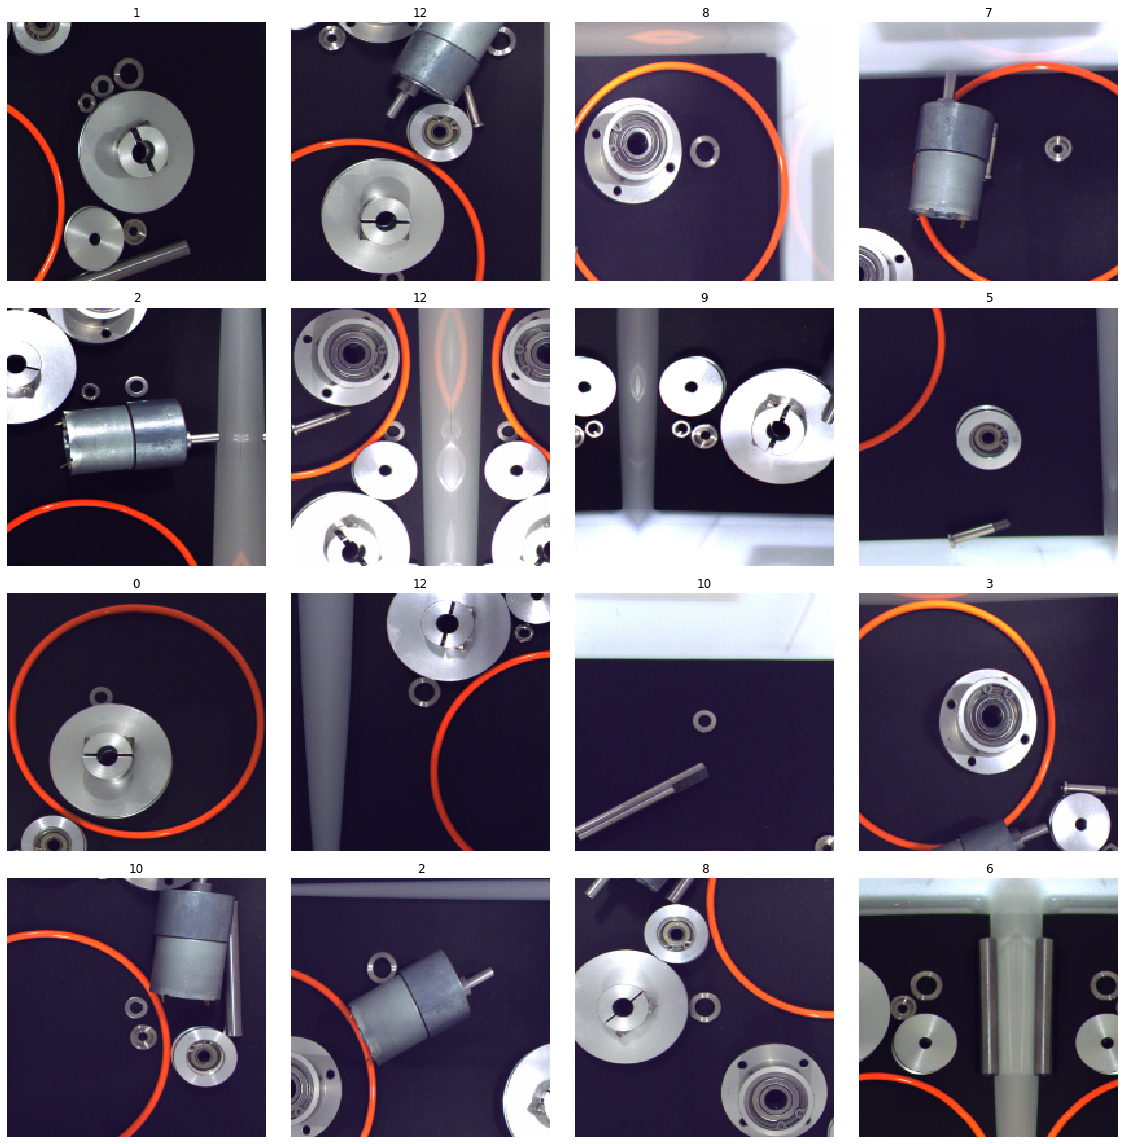

In [311]:
data.show_batch()

In [314]:
learn = None
gc.collect()

learn = cnn_learner(data, models.resnet18, metrics=accuracy, concat_pool=False)
body, head = learn.model.children()
adap_avg_pool, flatten, bn1, drop1, lin1, relu, bn2, drop2, lin2 = head.children()
class sel_center_features(nn.Module):
    def forward(self, x):
        _, _, h, w = x.shape
        return x[:, :, h//2, w//2]
new_head = nn.Sequential(sel_center_features(), bn1, drop1, lin1, relu, bn2, drop2, lin2)
learn.model = nn.Sequential(body, new_head)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


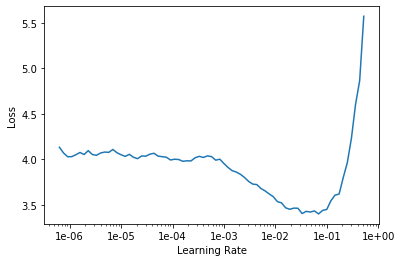

In [295]:
learn.lr_find()
learn.recorder.plot()

In [315]:
learn.fit_one_cycle(7, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.738638,1.197885,0.628617,01:00
1,1.260679,0.864060,0.734727,00:58
2,0.801319,0.681643,0.834405,01:01
3,0.435337,0.370665,0.901929,01:00
4,0.337896,0.288580,0.937299,00:59
5,0.213775,0.242534,0.940514,01:01
6,0.167653,0.244308,0.948553,00:59


In [316]:
learn.save('bg200-7-1e-2')

In [186]:
learn.load('bg10-1e-2')
pass

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


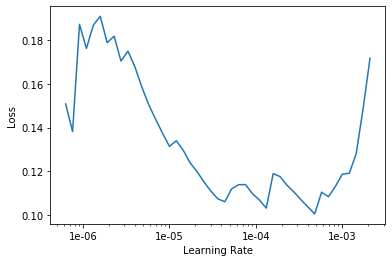

In [206]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [207]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.137186,0.173006,0.964630,00:59
1,0.144353,0.217552,0.958199,00:59
2,0.105222,0.139493,0.966238,01:00
3,0.108041,0.117517,0.963023,01:00
4,0.065508,0.118674,0.959807,00:59


In [208]:
learn.save('bg10-1e-2,u5-1e-5-1e-3')

In [301]:
interp = ClassificationInterpretation.from_learner(learn)

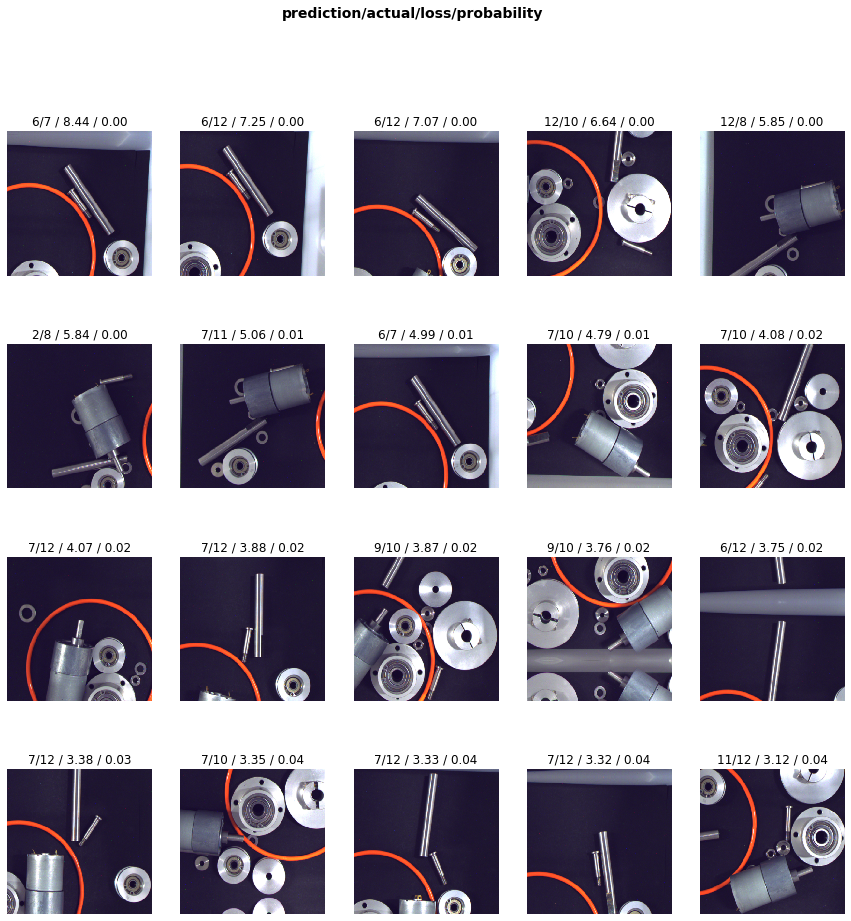

In [302]:
interp.plot_top_losses(20, figsize=(15, 15))

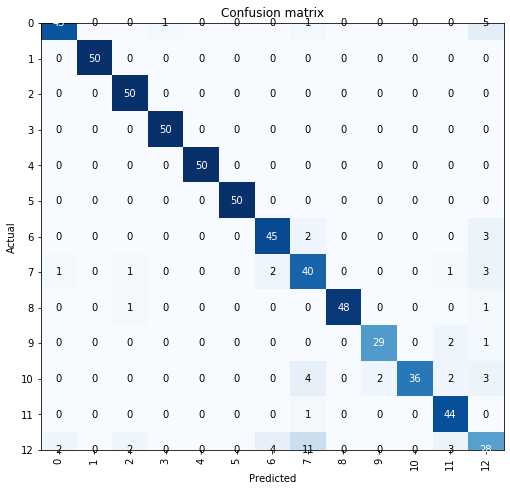

In [303]:
interp.plot_confusion_matrix(figsize=(7, 7))

In [317]:
conv1 = nn.Conv1d(512, 512, 1, 1)
conv1.weight.data = lin1.weight.data.view(512, 512, 1)
conv1.bias = lin1.bias

conv2 = nn.Conv1d(512, C, 1, 1)
conv2.weight.data = lin2.weight.data.view(C, 512, 1)
conv2.bias = lin2.bias

heat_head = [nn.Flatten(2), bn1, drop1, conv1, relu, bn2, drop2, conv2]
heat_model = nn.Sequential(body, *heat_head).to('cpu')

In [321]:
def heat_interlaced(img, res=4):
    step = 32 / res
    h, w = img.data.shape[1:]
    imgs = np.empty((res, res, 3, h, w))
    img = np.pad(img.data.numpy(), ((0,0), (16, 16), (16, 16)), 'symmetric')
    for y in range(res):
        for x in range(res):
            yy, xx = int(step * y), int(step * x)
            imgs[y, x] = img[:, yy:yy+h, xx:xx+w]
    return Tensor(imgs.reshape((res * res, 3, h, w)))

torch.Size([3, 320, 544])


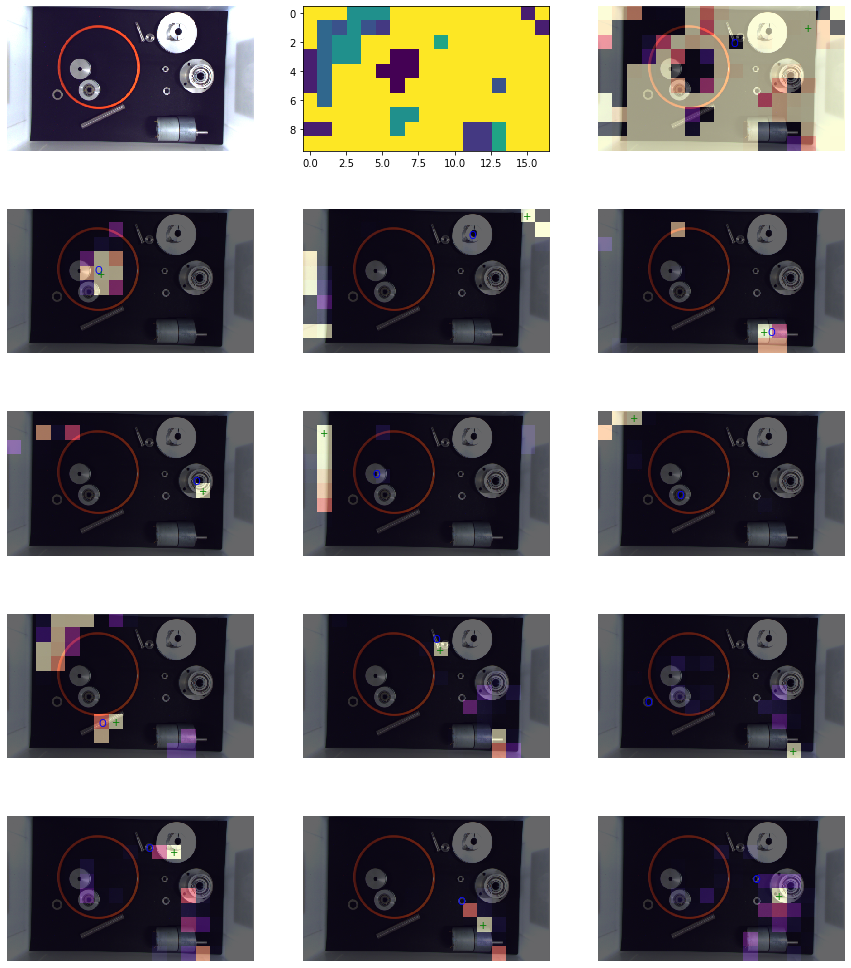

In [320]:
def open_wrs_img(p):
    imh = int((1200 * rf) // 32 * 32)
    imw = int((1920 * rf) // 32 * 32)
    img = open_image(p).resize((3, imh, imw))
    print(img.data.shape)
    return img
    
def norm(img):
    return normalize(img.data, *Tensor(imagenet_stats))

def softmax(lgts):
    lgts = lgts - lgts.max(axis=0, keepdims=True)
    elgts = np.exp(lgts)
    return elgts / elgts.sum(axis=0)

def show_sftmax_heatmap(scene_id, scene_i, res=4):
    img = open_wrs_img(Path() / "dataset" / "{}_{}.png".format(scene_id, scene_i))
    h, w = img.data.shape[1:]
    fh, fw = math.ceil(h/32) * res, math.ceil(w/32) * res
    img_norm = norm(img)
    imgs_interlaced = heat_interlaced(img_norm, res)
    out = heat_model.forward(imgs_interlaced).detach().numpy()
    lgts = np.empty((C, fh, fw))
    for 
    sftmax = softmax(lgts)
    fig, axs = plt.subplots(5, 3, figsize=(15, 18))
    img.show(ax=axs[0,0])
    c = sftmax.reshape(C, -1).argmax(axis=0).reshape(fh, fw)
    axs[0, 1].imshow(c)
    for i in range(C):
        p = sftmax[i]
        if i == C - 1: 
            ax = axs[0, 2]
        else:
            ax = axs[i // 3 + 1, i - (i // 3) * 3]
        amax = p.argmax()
        y = amax // p.shape[1]
        x = amax - y * p.shape[1]
        xx, yy = (x+.5)*32, (y+.5)*32
        img.show(ax=ax)
        ax.imshow(p, alpha=0.6, cmap='magma', interpolation='nearest', extent=(0, w, h, 0))
        anno_path = Path('annotations/{}_{}_{}'.format(scene_id, scene_i, i))
        if anno_path.exists():
            with open(anno_path) as f:
                xmin, ymin, xmax, ymax = map(int, f.readline().split(','))
            cx, cy = (xmin + xmax) / 2, (ymin + ymax) / 2
            ax.annotate('O', (cx * w / 1920, cy * h / 1200), ha='center', va='center', c='b')
        ax.annotate('+', (xx, yy), ha='center', va='center', c='g')
        #axs[0,0].annotate(obj_name[0], (xx, yy), ha='center', va='center', c='r')
        
show_sftmax_heatmap(22, 0)